## Creating synthetic data


Loading the VERDICT MODEL 
\begin{equation}
 E_{\textrm{VERDICT}}= \underbrace{f_{\textrm{Tumor}}\overbrace{E(D|\lambda_{\textrm{intra}})}^{\textrm{Sphere}}}_{\textrm{Tumor Cells}} + \underbrace{f_{\textrm{extra}}\overbrace{E(\cdot|\lambda_{iso})}^{\textrm{Ball}}}_{\textrm{Hindered Extra-Cellular}}+\underbrace{f_{blood}\overbrace{E(\lambda_\parallel, \boldsymbol{\mu})}^{\textrm{Stick}}}_{\textrm{Vascular}}
\end{equation}

In [3]:
# load the necessary modules
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel, MultiCompartmentSphericalHarmonicsModel
import numpy as np

sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])
verdict_mod.parameter_names

verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9) #2
verdict_mod.set_parameter_optimization_bounds('C1Stick_1_lambda_par', [3.05e-9, 10e-9])

Loading acquisition scheme

In [4]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join

acquisition_path_GS55 = "/Users/theavage/Documents/Master/Data/GS55 - long acquisition"

scheme= acquisition_scheme_from_schemefile(join(acquisition_path_GS55,"GS55_long_protocol2.scheme"))

## Creating parameter arrays

With random values of R and the IC,EES and VASC volume fractions

In [116]:
def all_comb(ic,ec,vasc,radi):

    comb= []

    for i in ic:
        for j in ec:
            for k in vasc:
                if i+j+k == 1:
                    for r in radi:
                        comb.append([r,2,1,3.05000000e-09,i,j,k])
    return comb

In [193]:
def fill(comb_arr,pixels):

    for i in range(pixels):
        comb_arr.append([np.random.uniform(0.001e-6,0.002e-6),2, 1, 3.05e-09,0.33,0.33,0.33])
    
    return comb_arr

In [289]:
ranges = np.arange(0.1,1.1,0.1)
ic = ranges; ec = ranges; vasc = ranges
radi = np.arange(0.02e-6,30e-6,1e-6)

all_combinations = all_comb(ic,ec,vasc,radi)

final = fill(all_combinations,4)

parameter_vector = np.array(final).reshape(32,32,7)


Visualization of the parameters:

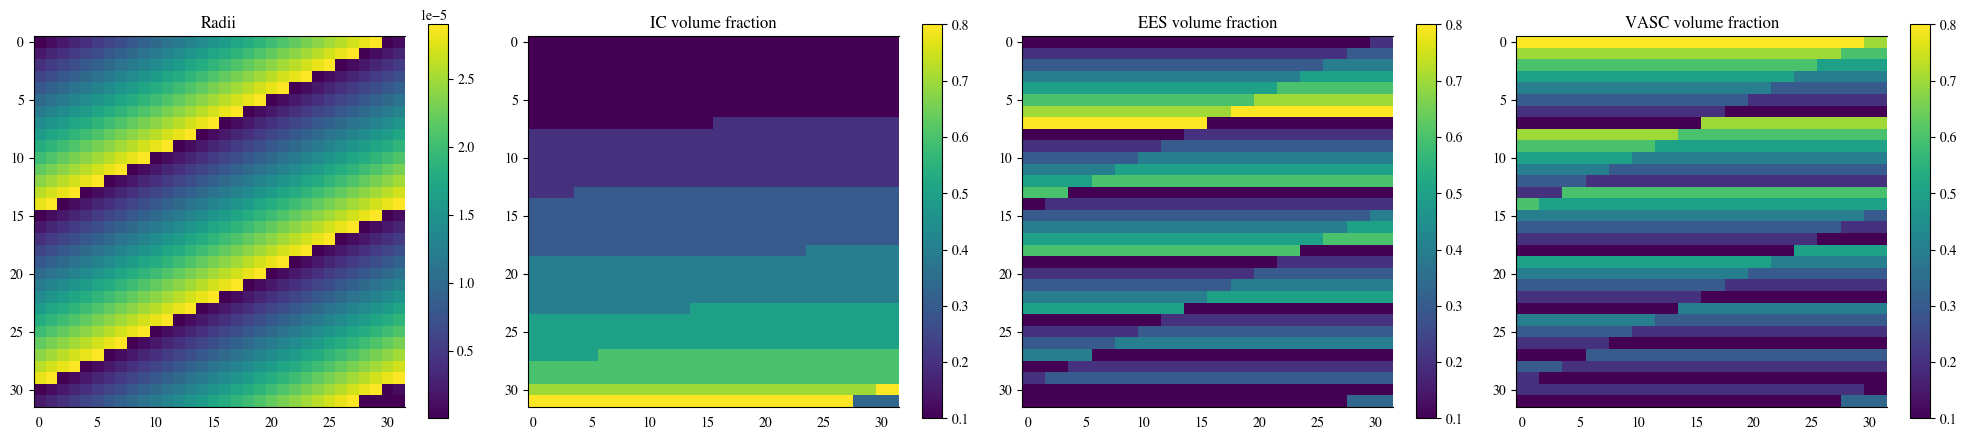

In [290]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import isin
%matplotlib inline

plt.rcParams["font.family"] = "times"
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

fig, ax = plt.subplots(1,4,figsize=(20,20))
names = ['Radii','IC volume fraction','EES volume fraction', 'VASC volume fraction']

image = ax[0].imshow(parameter_vector[:,:,0])
fig.colorbar(image,ax=ax[0],shrink=0.2)
ax[0].set_title(names[0])

for i in [1,2,3]:
    image = ax[i].imshow(parameter_vector[:,:,i+3])
    fig.colorbar(image,ax=ax[i],shrink=0.2)
    ax[i].set_title(names[i])



## Simulating new data from fake parameters
and visualizing 

In [195]:
simulated_signal = verdict_mod.simulate_signal(scheme,parameter_vector)

(32, 32, 160)

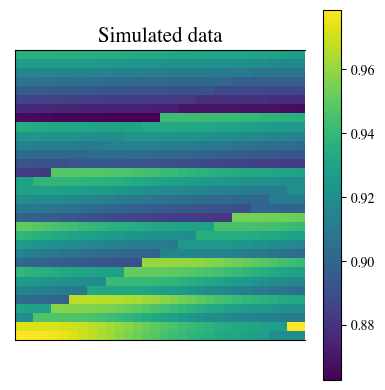

In [293]:
fig, ax = plt.subplots(1,figsize=(4,4))

image = ax.imshow(simulated_signal[:,:,1])
title = ax.set_title('Simulated data',fontsize=15)
cb = fig.colorbar(image,ax=ax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


## Adding noise

Normal distribution noise

In [227]:
noise = np.random.normal(0,.005,simulated_signal.shape)
new_signal = simulated_signal+noise

Rician distribution noise

In [294]:
from scipy.stats import rice

rician_noise = rice.rvs(1,0,0.01,size = simulated_signal.shape)
rician_image = simulated_signal+rician_noise

Visualizing images with noise

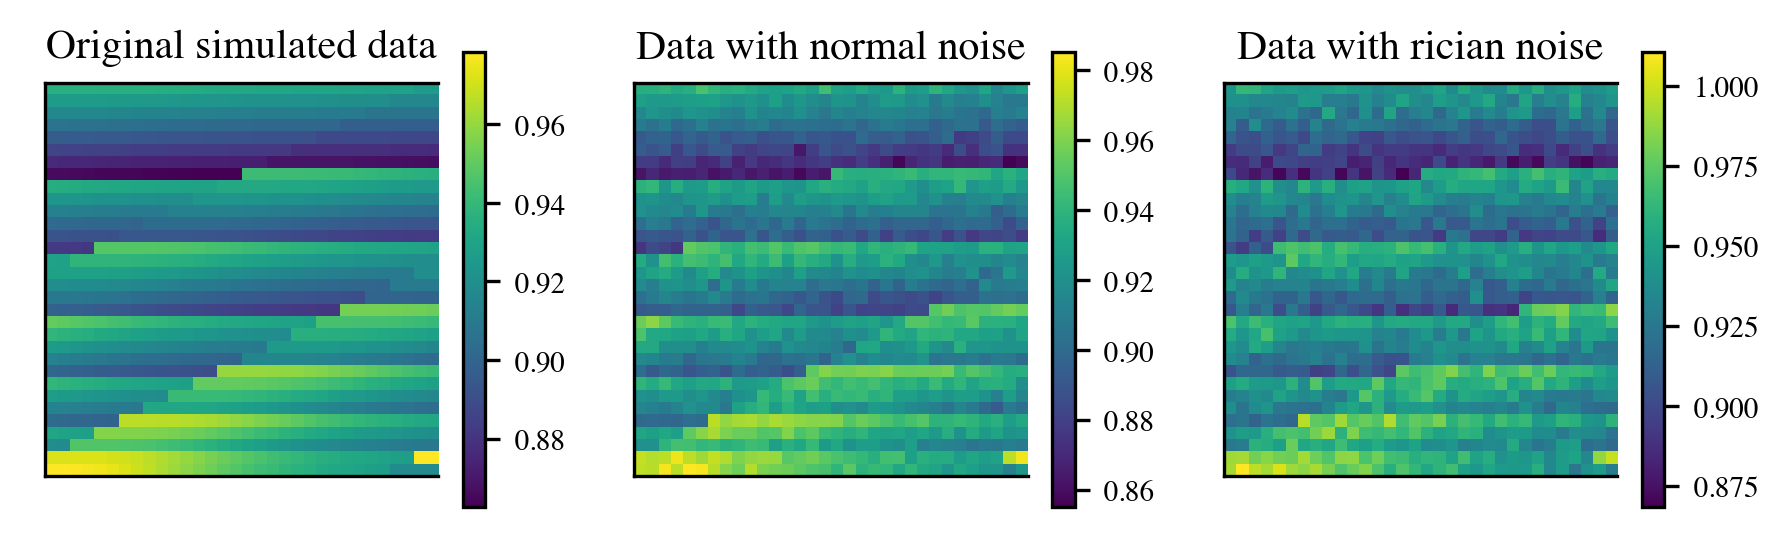

In [286]:
# Visualization

def plot_augmentations(images,names):
    fig,ax = plt.subplots(1,len(images))
    for i in range(len(images)):

        image = ax[i].imshow(images[i][:,:,1])
        title = ax[i].set_title(names[i],fontsize=10)
        cb = fig.colorbar(image,ax=ax[i],shrink=0.4)
        ax[i].get_xaxis().set_visible(False); ax[i].get_yaxis().set_visible(False)


plt.rcParams["font.family"] = "times"
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 7
plot_augmentations([simulated_signal,new_signal,rician_image],
    ['Original simulated data','Data with normal noise','Data with rician noise'])



## Testing

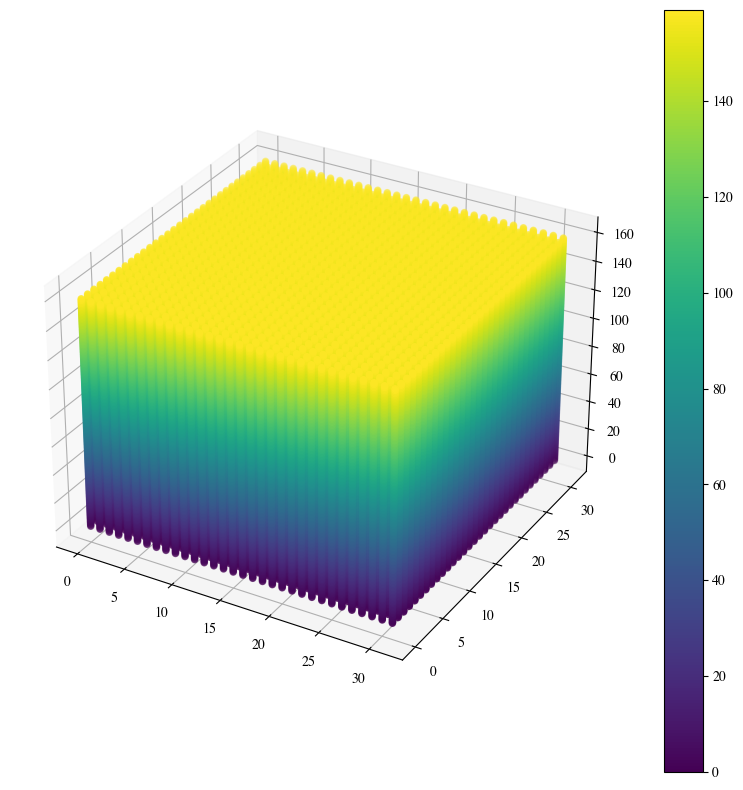

In [299]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = [8,8]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
image = fig.add_subplot(111,projection='3d')

x,y,z = simulated_signal.nonzero()

p = image.scatter3D(x,y,z,c=z)

fig.colorbar(p,ax=image)
